<a href="https://colab.research.google.com/github/bgohrani/Convolutional_Neural_Networks/blob/main/CNNs_continued.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error
import matplotlib.colors
import math
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import time
import seaborn as sns
import torchvision.models as models
import copy
import torchvision
from torchvision.transforms import transforms

#importing essential libraries

In [ ]:
!unzip data.zip

#We have loaded a custom data file containing some images from the ImageNet data set
#The total number of labels are also available to us in this folder
#The goal is to see how torchvision datasets can help us to load and get started with some local data that we have
#Using torchvision we can apply transformations needed and also use iterators during training

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/imagenet/
  inflating: data/imagenet/.DS_Store  
   creating: __MACOSX/data/imagenet/
  inflating: __MACOSX/data/imagenet/._.DS_Store  
   creating: data/imagenet/1/
  inflating: data/imagenet/1/stethoscope823-1.JPEG  
   creating: __MACOSX/data/imagenet/1/
  inflating: __MACOSX/data/imagenet/1/._stethoscope823-1.JPEG  
  inflating: data/imagenet/1/harmonica593-1.JPEG  
  inflating: __MACOSX/data/imagenet/1/._harmonica593-1.JPEG  
  inflating: data/imagenet/1/dome538-1.JPEG  
  inflating: __MACOSX/data/imagenet/1/._dome538-1.JPEG  
  inflating: data/imagenet/1/harmonica593-3.JPEG  
  inflating: __MACOSX/data/imagenet/1/._harmonica593-3.JPEG  
  inflating: data/imagenet/1/dome538-2.JPEG  
  inflating: __MACOSX/data/imagenet/1/._dome538-2.JPEG  
  inflating: data/imagenet/1/harmonica593-2.JPEG  
  inflati

In [ ]:
transform = torchvision.transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

#We set up the transformations needed, resizing the image so that we can match the input parameters of the network
#Converting to tensor and normalizing for better training and detection

In [ ]:
with open('data/imagenet_labels.txt') as f:
  classes = eval(f.read())

print(classes)

#There is a labels file inside our data which we want to open and see, the following code helps us do this

In [ ]:
testset = torchvision.datasets.ImageFolder(root='./data/imagenet', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle = True)

#Since the pretrained models are trained on the specific ImageNet dataset, we will not train anything here
#Our goal is to just visualize Convolutional Neural Networks, so we will create a testset taking the data that we have and transforming it
#Our testloader helps to shuffle the data and form batches of any given size

In [ ]:
data = iter(testloader)
images, labels = data.next()
print(images.shape)

#We take one image from this testloader and view its size
#1 corresponds to the batch size and 224x224x3 is the image size

torch.Size([1, 3, 224, 224])


In [ ]:
vgg = torchvision.models.vgg16(pretrained=True)

#We import the pretrained VGG-16 model here. This has already been trained on the ImageNet data as mentioned earlier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
def imshow(img, title):
  mean = np.asarray([0.485,0.456,0.406])
  std = np.asarray([0.229,0.224,0.225])

  denormalize = transforms.Normalize((-1 * mean/std),(1/std))
  img = denormalize(img)
  plt.imshow(np.transpose(img.numpy(),(1,2,0)))
  plt.axis('off')
  plt.title(title)

#Given an image, we want to view it with the help of matplotlib, so this function allows us to do so
#We need to reverse the transformations we made on the image so the denormalize line of code allows us to do so
#We can then convert to numpy, flip the dimensions and show, a title can also be given

def visualize_batch(dataloader,network,classes):
  dataiter = iter(dataloader)
  images,labels = dataiter.next()
  output = network(images)
  _,pred_classes = torch.max(output, axis=1)
  grid = torchvision.utils.make_grid(images)
  imshow(grid, title=[classes[x.item()] for x in pred_classes])

#This function allows us to view n number of images in a batch all at once
#We iterate through a given dataloader, pass the image through the network and call the imshow function above
#The predicted class is given as the title

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


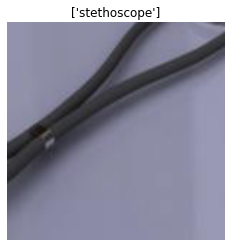

In [ ]:
visualize_batch(testloader,vgg,classes)

In [ ]:
data = iter(testloader)
input, label = data.next()
output = vgg(input)
print(output.shape)
pred_value, pred_class = torch.max(output, axis=1)
pred_probabilities = nn.functional.softmax(output, 1)
pred_prob, pred_prob_class = torch.max(pred_probabilities,axis =1 )
print(pred_class.item(), pred_prob.item(), pred_prob_class.item())

#We can see here that the network gives an output distributed over 1000 classes
#We take a softmax to get probabilities of all the classes and see the class with the max probability

torch.Size([1, 1000])
668 0.17579962313175201 668


In [ ]:
classes[pred_class.item()]

'mosque'

In [ ]:
def occlusion(model,image,given_prob_val,given_prob_position, occ_size = 50, occ_stride =50, occ_value = 0.5):

  new_image_width = int(np.ceil((image.shape[-2] - occ_size)/occ_stride))
  new_image_height = int(np.ceil((image.shape[-1] - occ_size)/occ_stride))
  heatmap = np.zeros([new_image_height+1,new_image_width+1])

  for w in tqdm_notebook(range(new_image_width+1)):
    for h in range(new_image_height+1):
      image_modified = copy.deepcopy(image)

      image_modified[: , : , (w * occ_size) : ((w * occ_size) + occ_size), (h * occ_size) : ((h * occ_size) + occ_size)] = occ_value
      output = model(image_modified)
      output_probabilities = nn.functional.softmax(output, 1)
      heatmap[w,h] = output_probabilities[0,given_prob_position]
      print(output_probabilities[0,given_prob_position])
      imshow(image_modified[0],'')
      plt.show()
  
  sns.heatmap(heatmap)
  plt.show()
  return heatmap

#This function implements what is known as occlusion, a concept in deep learning wherein we study what parts of an image contribute to the output the most
#This is done after our model has trained completely. We create patches in the image and pass it on to the network
#Since a part of the image is blacked out, the prediction might differ
#We use a heatmap to see which regions on blacking out affect the probability the most. Intuitionally, these should be the regions that contain the object we want to detect
#If our network predicts poorly when the region with the object is blacked out, it is a sign that our model has learnt to pick the right features

#This function first calculates the number of steps we would have to move our patch over the image based on the given occlusion size
#A heat map is created which shows the difference in probabilities for each region on blacking out
#We then iterate over the width and height, add the patch, pass the image through the network and give the probability value to the heatmap
#This heatmap is returned

In [ ]:
data = iter(testloader)
input, label = data.next()

#We'll take an image for occlusion

In [ ]:
output = vgg(input)
print(output.shape)
pred_value, pred_class = torch.max(output, axis=1)
pred_probabilities = nn.functional.softmax(output, 1)
pred_prob, pred_prob_class = torch.max(pred_probabilities,axis =1 )
print(pred_class.item(), pred_prob.item(), pred_prob_class.item())

#We pass the image through the network and get the predicted class

torch.Size([1, 1000])
823 0.920845091342926 823


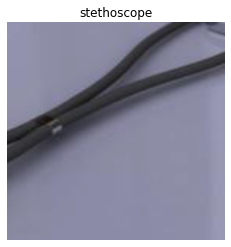

In [ ]:
imshow(input[0],classes[pred_prob_class.item()])

#Showing the image and the class with it

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


tensor(0.7793, grad_fn=<SelectBackward>)


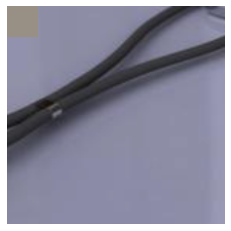

tensor(0.9067, grad_fn=<SelectBackward>)


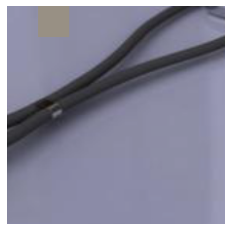

tensor(0.6002, grad_fn=<SelectBackward>)


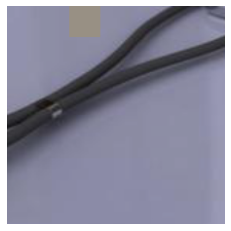

tensor(0.7790, grad_fn=<SelectBackward>)


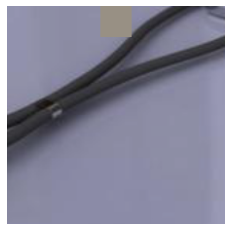

tensor(0.3680, grad_fn=<SelectBackward>)


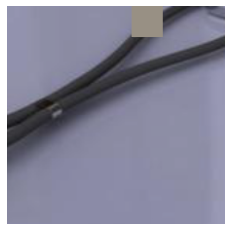

tensor(0.2603, grad_fn=<SelectBackward>)


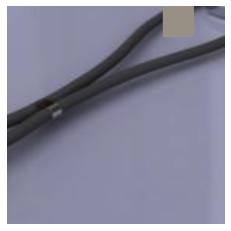

tensor(0.5693, grad_fn=<SelectBackward>)


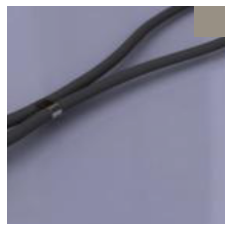

tensor(0.8731, grad_fn=<SelectBackward>)


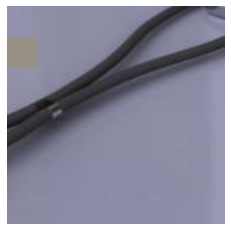

tensor(0.8600, grad_fn=<SelectBackward>)


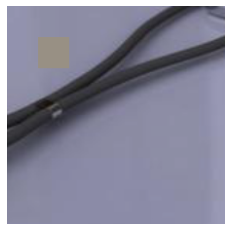

tensor(0.5929, grad_fn=<SelectBackward>)


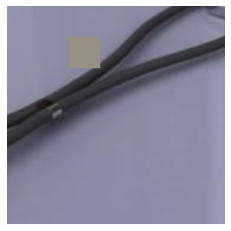

tensor(0.1876, grad_fn=<SelectBackward>)


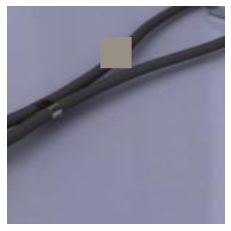

tensor(0.2319, grad_fn=<SelectBackward>)


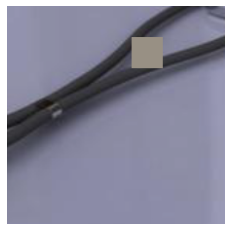

tensor(0.0994, grad_fn=<SelectBackward>)


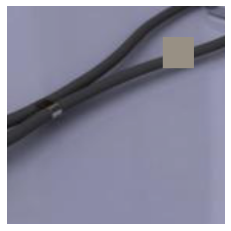

tensor(0.4624, grad_fn=<SelectBackward>)


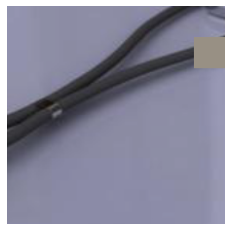

tensor(0.4991, grad_fn=<SelectBackward>)


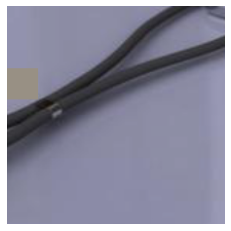

tensor(0.5683, grad_fn=<SelectBackward>)


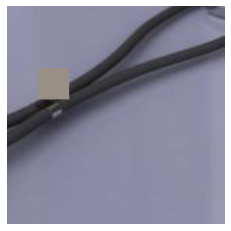

tensor(0.2090, grad_fn=<SelectBackward>)


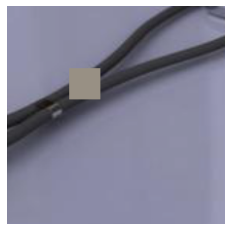

tensor(0.5067, grad_fn=<SelectBackward>)


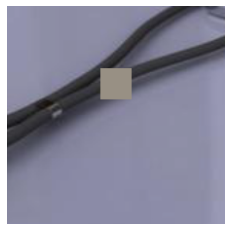

tensor(0.1813, grad_fn=<SelectBackward>)


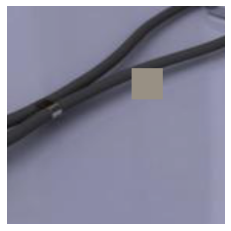

tensor(0.6840, grad_fn=<SelectBackward>)


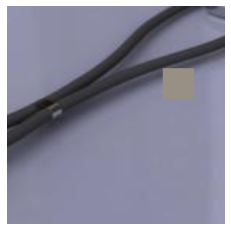

tensor(0.7915, grad_fn=<SelectBackward>)


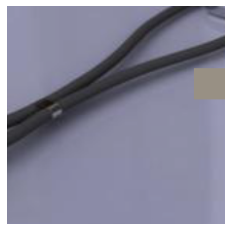

tensor(0.5550, grad_fn=<SelectBackward>)


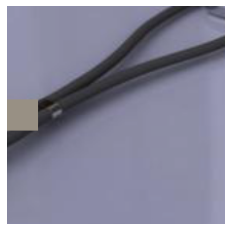

tensor(0.3145, grad_fn=<SelectBackward>)


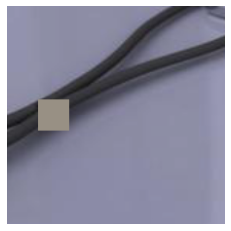

tensor(0.4383, grad_fn=<SelectBackward>)


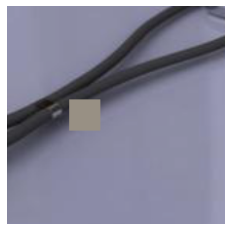

tensor(0.6721, grad_fn=<SelectBackward>)


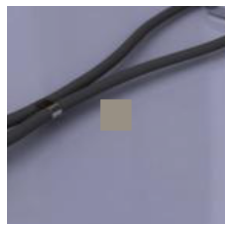

tensor(0.1479, grad_fn=<SelectBackward>)


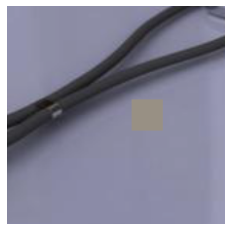

tensor(0.8554, grad_fn=<SelectBackward>)


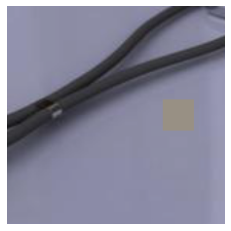

tensor(0.5893, grad_fn=<SelectBackward>)


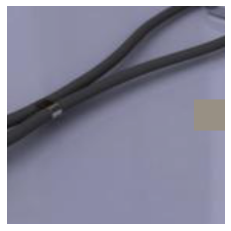

tensor(0.1969, grad_fn=<SelectBackward>)


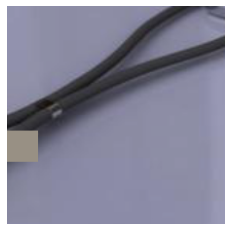

tensor(0.6936, grad_fn=<SelectBackward>)


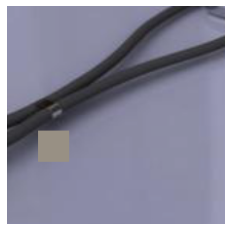

tensor(0.7073, grad_fn=<SelectBackward>)


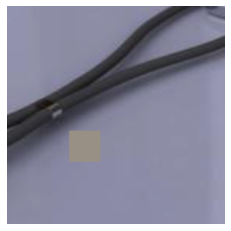

tensor(0.6045, grad_fn=<SelectBackward>)


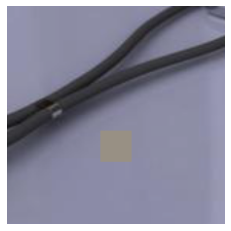

tensor(0.7663, grad_fn=<SelectBackward>)


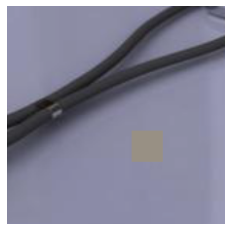

tensor(0.6375, grad_fn=<SelectBackward>)


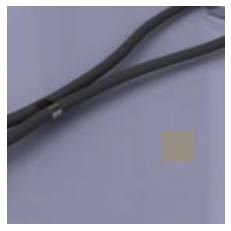

tensor(0.3894, grad_fn=<SelectBackward>)


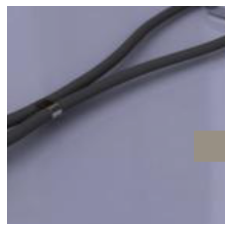

tensor(0.8464, grad_fn=<SelectBackward>)


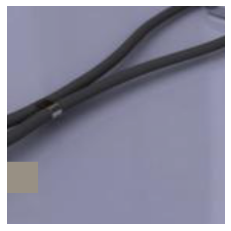

tensor(0.7348, grad_fn=<SelectBackward>)


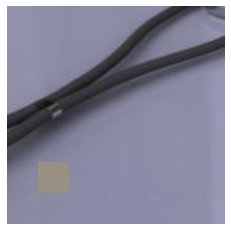

tensor(0.6006, grad_fn=<SelectBackward>)


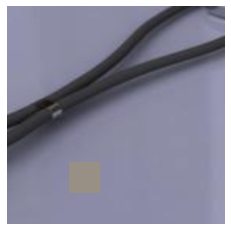

tensor(0.5736, grad_fn=<SelectBackward>)


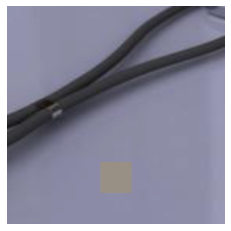

tensor(0.7657, grad_fn=<SelectBackward>)


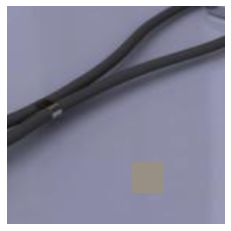

tensor(0.9315, grad_fn=<SelectBackward>)


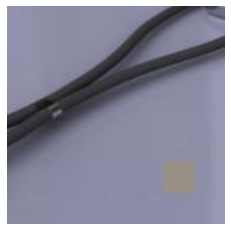

tensor(0.9687, grad_fn=<SelectBackward>)


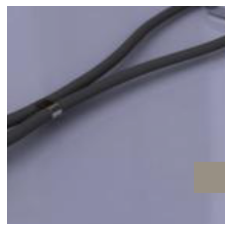

tensor(0.7437, grad_fn=<SelectBackward>)


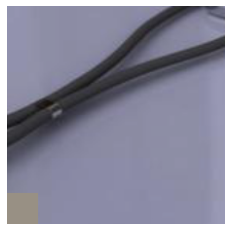

tensor(0.5225, grad_fn=<SelectBackward>)


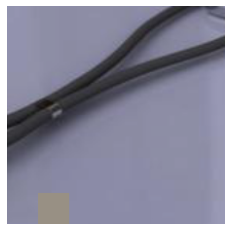

tensor(0.9384, grad_fn=<SelectBackward>)


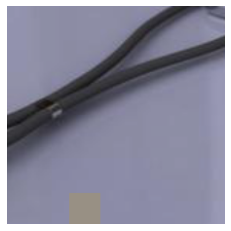

tensor(0.8117, grad_fn=<SelectBackward>)


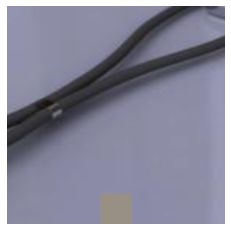

tensor(0.5747, grad_fn=<SelectBackward>)


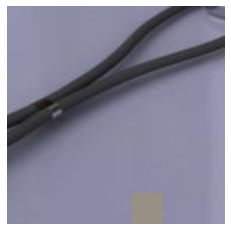

tensor(0.7785, grad_fn=<SelectBackward>)


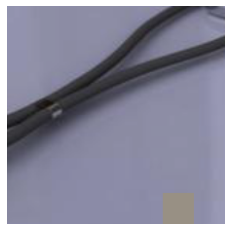

tensor(0.8207, grad_fn=<SelectBackward>)


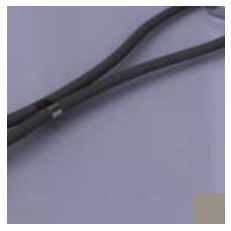

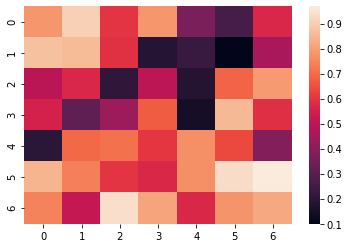

In [ ]:
ans = occlusion(vgg,input,pred_prob.item(),pred_class.item(),occ_size=32,occ_stride=32,occ_value=0.5)

#We run the occlusion for the image given above and below we can see at each time step, the image passed on to the network
#The patched part of the image is also shown along with the calculated probability
#The heatmap below shows the changes in probabilities
#For the stethoscope, changes are larger near the object and so our model predicts accurately

## Visualizing Convolution Filters


In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)
print(alexnet)

#We import the alexnet model with pre-trained weights

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
Conv = alexnet.features[0]
weight2 = Conv.weight.data
weight2.shape

#We want to visualize the filters that are used for prediction on the image net dataset
#The first layer of the Alexnet network takes in 3 channels as input and returns 64 channels. The kernel size is 11x11x3 and there are 64 such kernels 

torch.Size([64, 3, 11, 11])

In [ ]:
def plot_weights(network_point, individual_channels= True):
  images_batch = network_point.weight.data
  total_images = images_batch.shape[0]
  image_channels = images_batch.shape[1]
  print('Total images:',total_images)
  print('Total channels:',image_channels)
  print('Image size:',images_batch.shape[3],'x',images_batch.shape[2])
  if individual_channels == True:
    fig, axs = plt.subplots(image_channels,total_images,figsize= ((total_images*2),(image_channels*2)))
    k = 1
    for i in tqdm_notebook(range(image_channels)):
      for j in range(total_images):
        plt.subplot(image_channels,total_images,k)
        k +=1
        plt.axis('off')
        plt.title(str(j) +':'+ str())
        plt.gray()
        plt.imshow((np.transpose(images_batch[j][i].numpy(),(1,0))*255).astype(np.uint8), cmap='gray')
  else:
    if image_channels != 3:
      print('Only 3 channels are possible with color visualization')
    else:
      fig, axs = plt.subplots(4,int(total_images/4), figsize = ((total_images/2),8))
      for i in tqdm_notebook(range(total_images)):
        plt.subplot(4,int(total_images/4),(i+1))
        plt.axis('off')
        plt.title(str(i))
        plt.imshow((np.transpose(images_batch[i].numpy(),(1,2,0))*255).astype(np.uint8))

#This function helps us see what the kernels look like. It takes as input the layer of the network we want to visualize
#It then creates subplots based on the total number of images that have to be shown
#We then loop through each kernel and plot it by conversion to numpy. Some basic processing is done such that we can see it clearly     
#There is another parameter that the function takes, individual_channels which is true by default. If the kernel channels are 3, we can set it to false
#When individual_channels are false we can plot colour image of all three channels

Total images: 64
Total channels: 3
Image size: 11 x 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


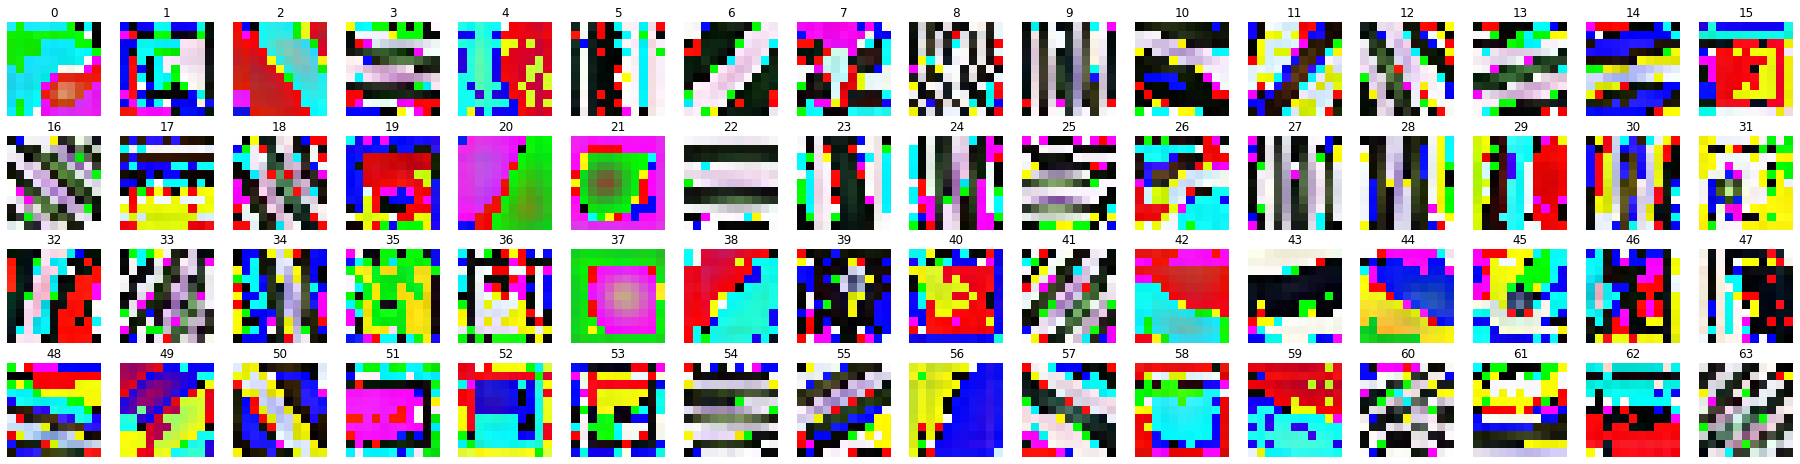

In [ ]:
plot_weights(alexnet.features[0],individual_channels=False)

#We plot the kernels with individual_channels as false so that all three channels are plotted
#64 images are plotted

Total images: 64
Total channels: 3
Image size: 11 x 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


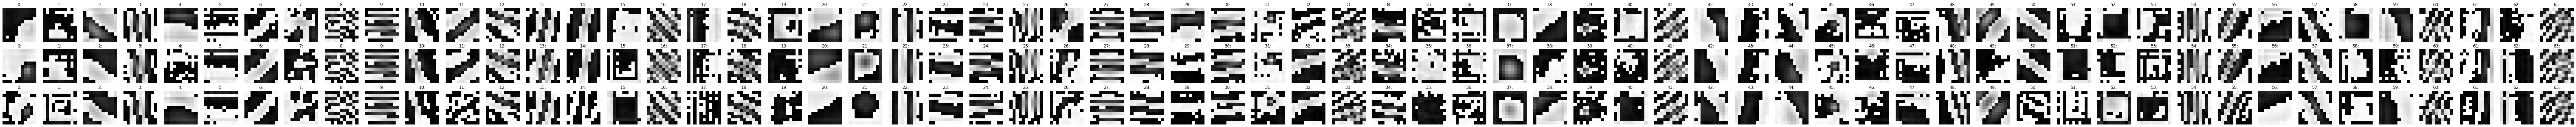

In [ ]:
plot_weights(alexnet.features[0],individual_channels=True)

#We plot the kernels with individual_channels as true so that single channels are plotted
#64x3 images are plotted

## Training on the CIFAR-10 Dataset

In [ ]:
device = torch.device('cuda')

# Implementing GPU hardware support

In [ ]:
train_transform = torchvision.transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = torchvision.transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#Adding the required transformations as usual

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True,transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=256,shuffle=True)
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',	'truck']		

#Importing the CIFAR-10 dataset and creating a dataloader to load images in batches as usual


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class CNN_cifar(nn.Module):

  def __init__(self):
    super(CNN_cifar,self).__init__()  #Check this 
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,96,3),   #(N,3,32,32) -> (N,96,30,30)
        nn.ReLU(),  #(N,96,30,30) --> (N,96,30,30)
        nn.Conv2d(96,96,3, stride=2),  #(N,96,30,30) -> (N,96,14,14)
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(96,192,3), #(N,96,14,14) -> (N,192,12,12)
        nn.ReLU(),
        nn.Conv2d(192,192,3,stride=2), #(N,192,12,12) -> (N,192,5,5)
        nn.ReLU(),
        nn.Dropout(0.5) #(N,192,5,5)
    )
  
    self.feedf = nn.Sequential(
        nn.BatchNorm1d(4800),
        nn.Linear(4800,256),
        nn.ReLU(),
        nn.Linear(256,10)
    )
    
  
  def forward(self,x):
    x1 = self.conv1(x)
    x2 = x1.view(x1.shape[0],-1)
    x3 = self.feedf(x2)

    return x3

#writing our own custom network to train on the dataset
#One convolutional sequential and one FeedForward sequential
#Output from the convolution layers is flattened before sending to the fully connected network

In [ ]:
cnn = CNN_cifar()
cnn = cnn.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(cnn.parameters())

#Instantiating our class and setting the loss criterion and optimizer as usual

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


10  batches loss =  1.8991070985794067
20  batches loss =  1.8340764045715332
30  batches loss =  1.7232190370559692
40  batches loss =  1.6950231790542603
50  batches loss =  1.6079342365264893
60  batches loss =  1.5791279077529907
70  batches loss =  1.4991289377212524
80  batches loss =  1.4679713249206543
90  batches loss =  1.418402910232544
100  batches loss =  1.5014984607696533
110  batches loss =  1.369459629058838
120  batches loss =  1.3392566442489624
130  batches loss =  1.2571321725845337
140  batches loss =  1.3954886198043823
150  batches loss =  1.388013482093811
160  batches loss =  1.3719615936279297
170  batches loss =  1.2858319282531738
180  batches loss =  1.2460441589355469
190  batches loss =  1.198379635810852
10  batches loss =  1.1283190250396729
20  batches loss =  1.0303022861480713
30  batches loss =  1.1227000951766968
40  batches loss =  1.137819766998291
50  batches loss =  1.2565606832504272
60  batches loss =  1.1767144203186035
70  batches loss =  

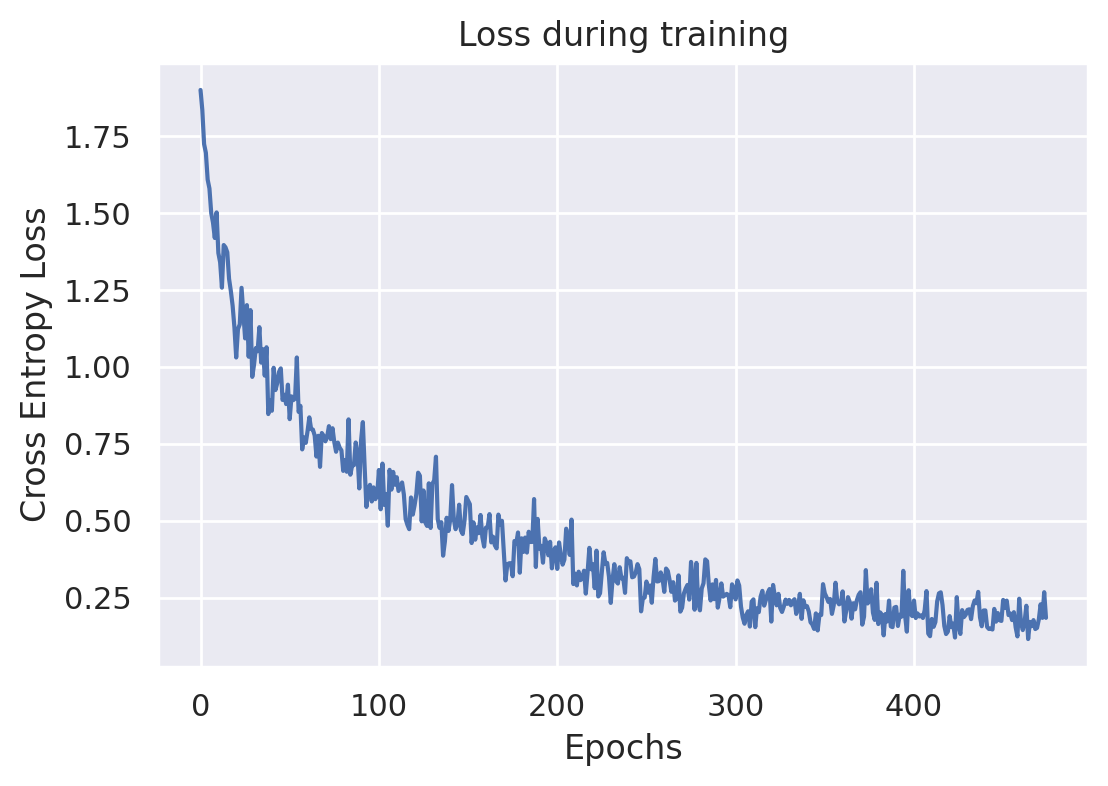

In [ ]:
epochs = 25
loss = []

for j in tqdm_notebook(range(epochs)): 
  k = 0
  for i, data in enumerate(trainloader,0):
    k += 1
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    output = cnn(inputs)
    loss_train = loss_func(output,labels)
    loss_train.backward()
    opt.step()


    del inputs, labels, output
    torch.cuda.empty_cache()
    if k%10 == 0:
      print(k,' batches','loss = ',loss_train.item())
      loss.append(loss_train.item())   

    


plt.figure(dpi =200)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss during training')
plt.show()

#Training loop same as earlier 

In [ ]:
def evaluation(dataloader, network):
  accuracy_count = 0
  total = 0
  for data in dataloader:
    input,labels = data
    input, labels = input.to(device), labels.to(device)
    output = network(input)
    total += labels.size(0)
    max_values1,max_classes1 = torch.max(output, axis=1)
    accuracy_count += (labels == max_classes1).sum().item()

  computed_accuracy = (accuracy_count/total)*100
  return computed_accuracy

#Here is our evaluation function
#We pass it any data (train/test loader and the network)
#It iterates over that, takes each batch with its inputs and labels
#Inputs are passed to the network, output is generated and compared to labels and accuracy count is maintained
#Total accuaracy_count is divided by total no of labels to give the answer in percentage
#Care is taken to move inputs and labels to device

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True,transform=test_transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=256,shuffle=False)

#Loading our test data to calculate accuracy

Files already downloaded and verified


In [ ]:
training_accuracy = evaluation(trainloader,cnn)
testing_accuracy = evaluation(testloader,cnn)
print(training_accuracy)
print(testing_accuracy)

#Better accuracies have been reached and some overfitting is observed

94.342
75.74


In [ ]:
class CNN_cifar2(nn.Module):

  def __init__(self):
    super(CNN_cifar2,self).__init__()  #Check this 
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,96,3),   #(N,3,32,32) -> (N,96,30,30)
        nn.BatchNorm2d(96),
        nn.ReLU(),  #(N,96,30,30) --> (N,96,30,30)
        nn.Dropout(0.5),
        nn.Conv2d(96,96,3, stride=2),  #(N,96,30,30) -> (N,96,14,14)
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Conv2d(96,192,3), #(N,96,14,14) -> (N,192,12,12)
        nn.BatchNorm2d(192),
        nn.ReLU(),
        nn.Conv2d(192,192,3,stride=2), #(N,192,12,12) -> (N,192,5,5)
        nn.BatchNorm2d(192),
        nn.ReLU(),
        nn.Dropout(0.5) #(N,192,5,5)
    )
  
    self.feedf = nn.Sequential(
        nn.BatchNorm1d(4800),
        nn.Linear(4800,256),
        nn.ReLU(),
        nn.Linear(256,10)
    )
    
  
  def forward(self,x):
    x1 = self.conv1(x)
    x2 = x1.view(x1.shape[0],-1)
    x3 = self.feedf(x2)

    return x3
  
#Our second network, deeper with more batchnorm and dropout layers to avoid overfitting on the data

In [ ]:
data = iter(trainloader)
inputs, labels = data.next()
inputs, labels = inputs.to(device), labels.to(device)

cnn = CNN_cifar2()
cnn = cnn.to(device)


loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(cnn.parameters(),weight_decay=5e-4)

#Setting up the training process

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


10  batches loss =  1.9610811471939087
20  batches loss =  1.7380682229995728
30  batches loss =  1.6728615760803223
40  batches loss =  1.7351000308990479
50  batches loss =  1.5189491510391235
60  batches loss =  1.5328105688095093
70  batches loss =  1.4862464666366577
80  batches loss =  1.6504957675933838
90  batches loss =  1.34221613407135
100  batches loss =  1.5277503728866577
110  batches loss =  1.3362683057785034
120  batches loss =  1.131041407585144
130  batches loss =  1.3570212125778198
140  batches loss =  1.2223737239837646
150  batches loss =  1.2860124111175537
160  batches loss =  1.2382912635803223
170  batches loss =  1.254241943359375
180  batches loss =  1.3718074560165405
190  batches loss =  1.1512839794158936
10  batches loss =  1.1468744277954102
20  batches loss =  1.0557029247283936
30  batches loss =  1.1214243173599243
40  batches loss =  1.08216392993927
50  batches loss =  1.164797067642212
60  batches loss =  1.086174726486206
70  batches loss =  1.0

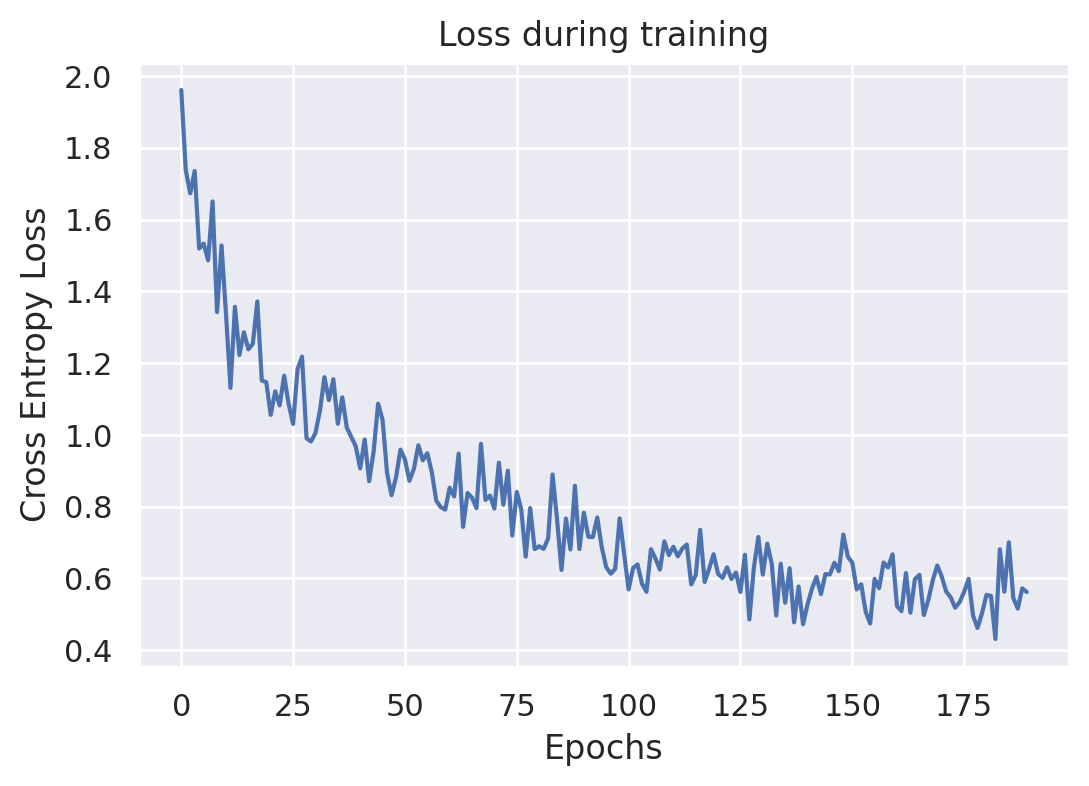

In [ ]:
epochs = 10
loss = []

for j in tqdm_notebook(range(epochs)): 
  k = 0
  for i, data in enumerate(trainloader,0):
    k += 1
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    output = cnn(inputs)
    loss_train = loss_func(output,labels)
    loss_train.backward()
    opt.step()


    del inputs, labels, output
    torch.cuda.empty_cache()
    if k%10 == 0:
      print(k,' batches','loss = ',loss_train.item())
      loss.append(loss_train.item())   

    


plt.figure(dpi =200)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss during training')
plt.show()

#Training loop same as earlier 

In [ ]:
training_accuracy = evaluation(trainloader,cnn)
testing_accuracy = evaluation(testloader,cnn)
print(training_accuracy)
print(testing_accuracy)

#Overall accuracy reduced but difference between training and test accuracies has also reduced so some overfitting is eliminated
#Longer training times and deeper networks can help us acheive higher accuracies

82.882
75.06
